In [1]:
from utils import * # custom packages for summer
import ipympl
from scipy import stats
%matplotlib inline
# %matplotlib widget

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 90% !important; }</style>"))

In [3]:
# Hyperparameters - network
input_size = 4
num_classes_mts = 1  # the number of units in the output layer for the match to sample task
num_classes_drc = 1  # the number of units in the output layer for the dual retro-cue task
hidden_size = 4  # the number of units in the recurrent layer
batch_size = 1  # batch size = # of samples to average when computing gradient
num_layers = 1  # number of stacked RNN/LSTM layers
eta = 0.005  # learning rate - note that the learning rate had to increase by a factor of 10
epochs = 1000  # epochs = # of full pases through dataset
threshold = 0.005
criterion = nn.BCELoss()  # loss function

In [9]:
# Hyperparameters - data generation & testing
num_networks = 25 # number of networks to average when calculating loss
generate_new = False # generates new datasets and targets (of the same type of task) for the network to train on
generate_random = True # shuffles the generated target and dataset order so the network doesn't simply learn the order of predictions to make but the type
same_distractions = False # makes the smame distractions as part of the distraction vector as opposed to different ones
verbosity = 0 # during training whether to show loss at each quarter of an epoch (1), and show predictive output at each quarter of an epoch (2), or nothing (0)

In [5]:
# Hyperparameters - match to sample
small_middle = [0, 3, 0] # small train in the middle (condition)
medium_middle = [0, 6, 0] # medium train in the middle (condition)
large_middle = [0, 20, 0] # large train in the middle (condition)
xlarge_middle = [0, 100, 0] # xlarge train in the middle (condition)

In [6]:
# Hyperparameters - dual retro-cue
small_small_delays = [3, 3] # two small delays
medium_medium_delays = [6, 6] # two medium delays
large_large_delays = [20, 20] # two small delays
xlarge_xlarge_delays = [100, 100] # two medium delays

# mts_seed = generate_dataset(input_size, seqlen1, seqlen2, seqlen3, same_distractions=same_distractions, random=generate_random) -- this is just for reference
# drc_seed = generate_dataset(input_size, seqlen1, seqlen2, seqlen3, same_distractions=same_distractions, random=generate_random) -- this is just for reference

In [7]:
def get_loss(test_type, network_type, num_networks, condition):
    
    availible_tests = ['dual_retro_cue', 'match_to_sample']
    availible_networks = ['vanilla', 'gru', 'lstm', 'rnncell', 'grucell', 'lstmcell']
        
    if (test_type in availible_tests) == False:
        print("Invalid test type, check your test type and try again")
        return
    
    if (network_type in availible_networks) == False:
        print("Invalid network type, check your network type and try again")
        return
        
    losses = []
    mean_loss = np.array([])
    
    seeds = []
    cell = False
    
    if verbosity > 0:
        print('\nLosses for', network_type, 'network:\n')
    
    if test_type == 'match_to_sample':
        seqlen1, seqlen2, seqlen3 = condition[0], condition[1], condition[2]
        
        for i in range(num_networks):
            if network_type == 'vanilla':
                seed = VanillaMTSNet(input_size, hidden_size, num_layers, num_classes_mts, batch_size, random_h0=True).to(device)
            if network_type == 'gru':
                seed = GRUMTSNet(input_size, hidden_size, num_classes_mts, batch_size, random_h0=True).to(device)
            if network_type == 'lstm':
                seed = LSTMMTSNet(input_size, hidden_size, num_layers, num_classes_mts, batch_size, random_h0=True, random_c0=True).to(device)
            if network_type == 'rnncell':
                cell = True
                seed = RNNCellMTSNet(input_size, hidden_size, num_classes_mts, batch_size, random_hx=True, random_cx=True).to(device)
            if network_type == 'grucell':
                cell = True
                seed = GRUCellMTSNet(input_size, hidden_size, num_classes_mts, batch_size, random_hx=True, random_cx=True).to(device)
            if network_type == 'lstmcell':
                cell = True
                seed = LSTMCellMTSNet(input_size, hidden_size, num_classes_mts, batch_size, random_hx=True, random_cx=True).to(device)
                
            # Loss function, optimizer, and schedule (for decaying learning rate)
            optimizer = optim.Adam(seed.parameters(), eta)  # tells optimizer to adjust all parameter weights with steps based on eta
            sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=False) # lowers lr if the loss global min doesn't decrease for 5 epochs
            dataset, targets, sequence_length = generate_dataset(input_size, seqlen1, seqlen2, seqlen3, same_distractions=same_distractions, random=generate_random, test_type=test_type)
            loss = train_network(seed, dataset, targets, sequence_length, input_size, batch_size, epochs, optimizer, criterion, sheduler, generate_new=generate_new, generate_random=generate_random, same_distractions=same_distractions, condition=condition, verbosity=verbosity, cell=cell)

            if i == 0:
                mean_loss = loss
            else:
                mean_loss = mean_loss + loss

            seeds.append(seed)
            losses.append(loss)
        
    if test_type == 'dual_retro_cue':
        seqlen1, seqlen2 = condition[0], condition[1]
        
        for i in range(num_networks):
            if network_type == 'vanilla':
                seed = VanillaDRCNet(input_size, hidden_size, num_layers, num_classes_drc, batch_size, seqlen1, seqlen2, random_h0=True, random_c0=True).to(device)
            if network_type == 'gru':
                seed = GRUDRCNet(input_size, hidden_size, num_layers, num_classes_drc, batch_size, seqlen1, seqlen2, random_h0=True, random_c0=True).to(device)
            if network_type == 'lstm':
                seed = LSTMDRCNet(input_size, hidden_size, num_layers, num_classes_drc, batch_size, seqlen1, seqlen2, random_h0=True, random_c0=True).to(device)
            if network_type == 'rnncell':
                cell = True
                seed = RNNCellDRCNet(input_size, hidden_size, num_classes_drc, batch_size, seqlen1, seqlen2, random_hx=True, random_cx=True).to(device)
            if network_type == 'grucell':
                cell = True
                seed = GRUCellDRCNet(input_size, hidden_size, num_classes_drc, batch_size, seqlen1, seqlen2, random_hx=True, random_cx=True).to(device)
            if network_type == 'lstmcell':
                cell = True
                seed = LSTMCellDRCNet(input_size, hidden_size, num_classes_drc, batch_size, seqlen1, seqlen2, random_hx=True, random_cx=True).to(device)
                
            # Loss function, optimizer, and schedule (for decaying learning rate)
            optimizer = optim.Adam(seed.parameters(), eta)  # tells optimizer to adjust all parameter weights with steps based on eta
            sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=False) # lowers lr if the loss global min doesn't decrease for 5 epochs
            dataset, targets, sequence_length = generate_dataset(input_size, seqlen1, seqlen2, same_distractions=same_distractions, random=generate_random, test_type=test_type)
            loss = train_network(seed, dataset, targets, sequence_length, input_size, batch_size, epochs, optimizer, criterion, sheduler, generate_new=generate_new, generate_random=generate_random, same_distractions=same_distractions, condition=condition, verbosity=verbosity, cell=cell, test_type=test_type)

            if i == 0:
                mean_loss = loss
            else:
                mean_loss = mean_loss + loss

            seeds.append(seed)
            losses.append(loss)
    
    losses = np.array(losses)
    mean_loss = mean_loss/num_networks
    return mean_loss, losses, seeds

In [10]:
# Match to Sample Networks with Vanilla RNN
mean_loss_small_rnncell_mts,losses_small_rnncell_mts,_ = get_loss('match_to_sample', 'rnncell', num_networks, small_middle)
mean_loss_large_rnncell_mts,losses_large_rnncell_mts,_ = get_loss('match_to_sample', 'rnncell', num_networks, large_middle)

In [11]:
## Optonal: GRU-Based Networks for MTS Task ##
# mean_loss_small_grucell_mts,losses_small_grucell_mts,_ = get_loss('match_to_sample', 'grucell', num_networks, small_middle)
# mean_loss_large_grucell_mts,losses_large_grucell_mts,_ = get_loss('match_to_sample', 'grucell', num_networks, large_middle)

In [12]:
# Match to Sample Networks with LSTM
mean_loss_small_lstmcell_mts,losses_small_lstmcell_mts,_ = get_loss('match_to_sample', 'lstmcell', num_networks, small_middle)
mean_loss_large_lstmcell_mts,losses_large_lstmcell_mts,_ = get_loss('match_to_sample', 'lstmcell', num_networks, large_middle)

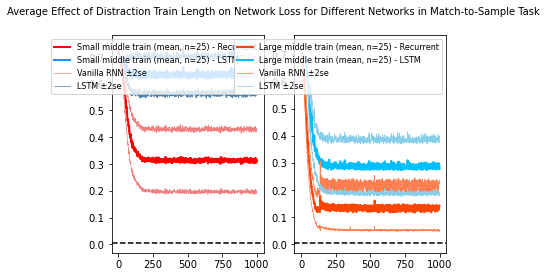

In [13]:
### Plots for MTS Task ###

fig, ax = plt.subplots(1,2)

# plot losses
fig.suptitle("Average Effect of Distraction Train Length on Network Loss for Different Networks in Match-to-Sample Task", fontsize=10)

## Mean losses
ax[0].plot(mean_loss_small_rnncell_mts, color='red', label="Small middle train (mean, n=" + str(num_networks) + ") - Recurrent", linewidth=2)
ax[0].plot(mean_loss_small_lstmcell_mts, color='dodgerblue', label="Small middle train (mean, n=" + str(num_networks) + ") - LSTM", linewidth=2)

ax[1].plot(mean_loss_large_rnncell_mts, color='orangered', label="Large middle train (mean, n=" + str(num_networks) + ") - Recurrent", linewidth=2)
ax[1].plot(mean_loss_large_lstmcell_mts, color='deepskyblue', label="Large middle train (mean, n=" + str(num_networks) + ") - LSTM", linewidth=2)

## Vanilla standard deviations
ax[0].plot((mean_loss_small_rnncell_mts + 2*stats.sem(losses_small_rnncell_mts, axis=0, ddof=0)), color='lightcoral', label="Vanilla RNN ±2se", linewidth=0.7) # small case
ax[0].plot((mean_loss_small_rnncell_mts - 2*stats.sem(losses_small_rnncell_mts, axis=0, ddof=0)), color='lightcoral', linewidth=0.7) # small case

ax[1].plot((mean_loss_large_rnncell_mts + 2*stats.sem(losses_large_rnncell_mts, axis=0, ddof=0)), color='coral', label="Vanilla RNN ±2se", linewidth=0.7) # large case
ax[1].plot((mean_loss_large_rnncell_mts - 2*stats.sem(losses_large_rnncell_mts, axis=0, ddof=0)), color='coral', linewidth=0.7) # large case


## LSTM standard deviations
ax[0].plot((mean_loss_small_lstmcell_mts + 2*stats.sem(losses_small_lstmcell_mts, axis=0, ddof=0)), color='steelblue', label="LSTM ±2se", linewidth=0.7) # small case
ax[0].plot((mean_loss_small_lstmcell_mts - 2*stats.sem(losses_small_lstmcell_mts, axis=0, ddof=0)), color='steelblue', linewidth=0.7) # small case

ax[1].plot((mean_loss_large_lstmcell_mts + 2*stats.sem(losses_large_lstmcell_mts, axis=0, ddof=0)), color='skyblue', label="LSTM ±2se", linewidth=0.7) # large case
ax[1].plot((mean_loss_large_lstmcell_mts - 2*stats.sem(losses_large_lstmcell_mts, axis=0, ddof=0)), color='skyblue', linewidth=0.7) # large case

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[0].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.
ax[1].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.


plt.show()

In [14]:
# DRC Task with Vanilla RNN
mean_loss_small_rnncell_drc,losses_small_rnncell_drc,_ = get_loss('dual_retro_cue', 'rnncell', num_networks, small_small_delays)
mean_loss_large_rnncell_drc,losses_large_rnncell_drc,_ = get_loss('dual_retro_cue', 'rnncell', num_networks, large_large_delays)

In [15]:
## Optonal: GRU-Based Networks for DRC Task ##
# mean_loss_small_grucell_drc,losses_small_grucell_drc,_ = get_loss('dual_retro_cue', 'grucell', num_networks, small_small_delays)
# mean_loss_small_grucell_drc,losses_small_grucell_drc,_ = get_loss('dual_retro_cue', 'grucell', num_networks, large_large_delays)

In [16]:
# DRC Task with LSTM
mean_loss_small_lstmcell_drc,losses_small_lstmcell_drc,_ = get_loss('dual_retro_cue', 'lstmcell', num_networks, small_small_delays)
mean_loss_large_lstmcell_drc,losses_large_lstmcell_drc,_ = get_loss('dual_retro_cue', 'lstmcell', num_networks, large_large_delays)

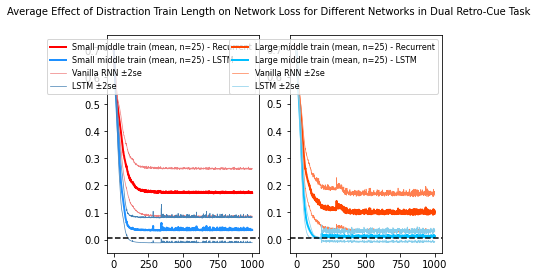

In [17]:
### Plots for DRC Task ###

fig, ax = plt.subplots(1,2)

# plot losses
fig.suptitle("Average Effect of Distraction Train Length on Network Loss for Different Networks in Dual Retro-Cue Task", fontsize=10)

## Mean losses
ax[0].plot(mean_loss_small_rnncell_drc, color='red', label="Small middle train (mean, n=" + str(num_networks) + ") - Recurrent", linewidth=2)
ax[0].plot(mean_loss_small_lstmcell_drc, color='dodgerblue', label="Small middle train (mean, n=" + str(num_networks) + ") - LSTM", linewidth=2)

ax[1].plot(mean_loss_large_rnncell_drc, color='orangered', label="Large middle train (mean, n=" + str(num_networks) + ") - Recurrent", linewidth=2)
ax[1].plot(mean_loss_large_lstmcell_drc, color='deepskyblue', label="Large middle train (mean, n=" + str(num_networks) + ") - LSTM", linewidth=2)

## Vanilla standard deviations
ax[0].plot((mean_loss_small_rnncell_drc + 2*stats.sem(losses_small_rnncell_drc, axis=0, ddof=0)), color='lightcoral', label="Vanilla RNN ±2se", linewidth=0.7) # small case
ax[0].plot((mean_loss_small_rnncell_drc - 2*stats.sem(losses_small_rnncell_drc, axis=0, ddof=0)), color='lightcoral', linewidth=0.7) # small case

ax[1].plot((mean_loss_large_rnncell_drc + 2*stats.sem(losses_large_rnncell_drc, axis=0, ddof=0)), color='coral', label="Vanilla RNN ±2se", linewidth=0.7) # large case
ax[1].plot((mean_loss_large_rnncell_drc - 2*stats.sem(losses_large_rnncell_drc, axis=0, ddof=0)), color='coral', linewidth=0.7) # large case


## LSTM standard deviations
ax[0].plot((mean_loss_small_lstmcell_drc + 2*stats.sem(losses_small_lstmcell_drc, axis=0, ddof=0)), color='steelblue', label="LSTM ±2se", linewidth=0.7) # small case
ax[0].plot((mean_loss_small_lstmcell_drc - 2*stats.sem(losses_small_lstmcell_drc, axis=0, ddof=0)), color='steelblue', linewidth=0.7) # small case

ax[1].plot((mean_loss_large_lstmcell_drc + 2*stats.sem(losses_large_lstmcell_drc, axis=0, ddof=0)), color='skyblue', label="LSTM ±2se", linewidth=0.7) # large case
ax[1].plot((mean_loss_large_lstmcell_drc - 2*stats.sem(losses_large_lstmcell_drc, axis=0, ddof=0)), color='skyblue', linewidth=0.7) # large case

# Threshold line
ax[0].axhline(threshold, linestyle='dashed', color='black')
ax[1].axhline(threshold, linestyle='dashed', color='black')

# legend and show plot
ax[0].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.
ax[1].legend(fontsize=8, loc="upper right") # by default, the legend ignores all elements without a label attribute set.


plt.show()